In [1]:
import glob
import re
from util import get_meta_information
from LightCurve import CRTS_VS_LightCurve

def load_data(file_name_list, GP_model=False):
    '''
    读取单个类的数据
    将原始数据读取为LightCurve对象，并进行预处理
    '''
    info_file = 'data/SSS_Per_Tab.txt'
    info = get_meta_information(info_file)
    lc_list = []
    for name in file_name_list:
        split_name = re.match(r'(data/original_data/type/)(\d{1,2})(/)(\d{11,14})(\w{0,15}).dat',name)
        class_label = split_name.group(2)
        lc = CRTS_VS_LightCurve()
        lc.class_label = class_label
        lc.read_CRTS_dat(name, id=split_name.group(4))
        period = info.loc[int(lc.id), 'Period']
        lc.fold(2 * period, normalize_phase=True, normalize_section=[0,2]) #为了展示，改为两倍周期折叠
        lc.clean()
        if GP_model == True:
            try:
                lc.fit_GP_model()
            except:
                print('there is an error when fit GP_model, class_label=%s, id=%s'%(lc.class_label,lc.id))
                lc.show()
        lc_list.append(lc)
    print('load %d files'%len(file_name_list))
    return lc_list

RRab_name_list = glob.glob('data/original_data/type/1/*.dat')
Ecl_name_list = glob.glob('data/original_data/type/5/*.dat')
EA_name_list = glob.glob('data/original_data/type/6/*.dat')
LPV_name_list = glob.glob('data/original_data/type/8/*.dat')
DS_name_list = glob.glob('data/original_data/type/9/*.dat')
ACEP_name_list = glob.glob('data/original_data/type/10/*.dat')
RRab_lc_list = load_data(RRab_name_list)
Ecl_lc_list = load_data(Ecl_name_list)
EA_lc_list = load_data(EA_name_list)
LPV_lc_list = load_data(LPV_name_list)
DS_lc_list = load_data(DS_name_list)
ACEP_lc_list = load_data(ACEP_name_list)

load 4325 files
load 18803 files
load 4509 files
load 1286 files
load 147 files
load 153 files


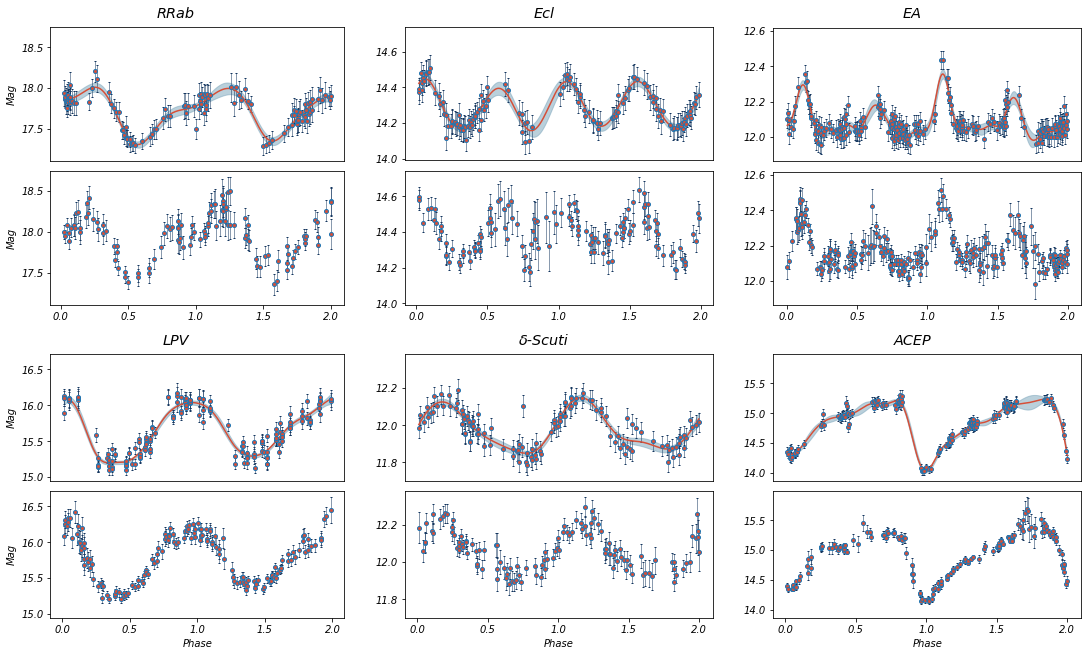

In [143]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib


params={'font.family':'serif',
        'font.serif':'Times New Roman',
        'font.style':'italic',
        'font.weight':'normal'
        # 'font.size':'medium',#or large,small
        }
plt.rcParams.update(params)

fig = plt.figure(constrained_layout=True, figsize=(15, 9))
fig.set_facecolor('w')
subfigs = fig.subfigures(nrows=2, ncols=3, wspace=0.07)

def subfigure_plot(subfugs, lc, row, col, x_label=False, y_label=False, name=''):
    lc.GP_smooth()
    x = np.array(lc.data['phase'])
    y = np.array(lc.data[lc.measurement])
    err = np.array(lc.data[lc.error])
    x_pred = np.linspace(0,2,300)
    pred,pred_var = lc.GP_model.predict(y, x_pred, return_var=True)
    x_simu = np.random.uniform(low=0,high=lc.phase_span, size=len(lc))
    x_simu = np.sort(x_simu)
    simu_lc = lc.generate_GP_simulation(x_simu)
    y_simu = simu_lc.data[simu_lc.measurement]
    err_simu = simu_lc.data[simu_lc.error]

    axs = subfigs[row][col].subplots(2, 1, sharey=True)
    subfigs[row][col].set_facecolor('w')
    subfigs[row][col].suptitle(name, fontsize='x-large')
    axtop = axs[0]
    if y_label is True:
        axtop.set_ylabel('Mag')
    axtop.errorbar(x,y,err, fmt='o',ms=4, mfc=[0.839,0.31,0.22], ecolor=[0.078,0.212,0.373],elinewidth=0.5, capsize=1)
    axtop.plot(x_pred,pred,color=[0.839,0.31,0.22])
    axtop.fill_between(x_pred,pred-np.sqrt(pred_var),pred+np.sqrt(pred_var),color=[0.463,0.635,0.725], alpha=0.5)
    axtop.axes.xaxis.set_visible(False)
    axbottom = axs[1]
    if x_label is True:
        axbottom.set_xlabel('Phase')
    if y_label is True:
        axbottom.set_ylabel('Mag')
    axbottom.errorbar(x_simu,y_simu,err_simu, fmt='o',ms=4, mfc=[0.839,0.31,0.22], ecolor=[0.078,0.212,0.373],elinewidth=0.5, capsize=1)
    axbottom.axes.xaxis.set_ticks([0.0,0.5,1.0,1.5,2.0])

lc = RRab_lc_list[43]
subfigure_plot(subfigs, lc, 0, 0, y_label=True, name='RRab')
lc = Ecl_lc_list[7]
subfigure_plot(subfigs, lc, 0, 1, name='Ecl')
lc = EA_lc_list[2]
subfigure_plot(subfigs, lc, 0, 2, name='EA')
lc = LPV_lc_list[8]
subfigure_plot(subfigs, lc, 1, 0, x_label=True, y_label=True, name='LPV')
lc = DS_lc_list[134]
subfigure_plot(subfigs, lc, 1, 1, x_label=True, name='δ-Scuti')
lc = ACEP_lc_list[2]
subfigure_plot(subfigs, lc, 1, 2, x_label=True, name='ACEP')

# [0.973,0.95,0.922]
plt.show()

In [22]:
import itertools

def plot_4_confusion_matrixs(cm1,cm2,cm3,cm4, 
                          classes_types,
                          normalize=True,
                          title1='Confusion matrix for ensemble RNN-based model',
                          title2='Confusion matrix for RNN-based model with equal augmentation',
                          title3='Confusion matrix for RNN-based model with class weights',
                          title4='Confusion matrix for SPE classifier',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis] * 100
        cm2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis] * 100
        cm3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis] * 100
        cm4 = cm4.astype('float') / cm4.sum(axis=1)[:, np.newaxis] * 100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    

    fig = plt.figure(figsize=(22,22))

    plt.subplot(221)
    plt.imshow(cm1, interpolation='nearest', cmap=cmap)
    plt.title(title1, fontsize=16)
    cb=plt.colorbar(fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=16)
    tick_marks = np.arange(len(classes_types))
    plt.xticks(tick_marks, classes_types, rotation=45)
    plt.yticks(tick_marks, classes_types)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)

    thresh = cm1.max() / 2.
    for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
        plt.text(j, i, "{:0.1f}".format(cm1[i, j]),
                 horizontalalignment="center",
                 color="white" if (cm1[i, j] < 0.01) or (cm1[i,j] >= 0.75)  else "black",fontsize=18)

    plt.ylabel('True label',fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)
    plt.tight_layout()

    plt.subplot(222)
    plt.imshow(cm2, interpolation='nearest', cmap=cmap)
    plt.title(title2, fontsize=16)
    cb=plt.colorbar(fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=16)
    tick_marks = np.arange(len(classes_types))
    plt.xticks(tick_marks, classes_types, rotation=45)
    plt.yticks(tick_marks, classes_types)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)

    thresh = cm2.max() / 2.
    for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
        plt.text(j, i, "{:0.1f}".format(cm2[i, j]),
                 horizontalalignment="center",
                 color="white" if (cm2[i, j] < 0.01) or (cm2[i,j] >= 0.75)  else "black",fontsize=18)

    plt.ylabel('True label',fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)
    plt.tight_layout()

    plt.subplot(223)
    plt.imshow(cm3, interpolation='nearest', cmap=cmap)
    plt.title(title3, fontsize=16)
    cb=plt.colorbar(fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=16)
    tick_marks = np.arange(len(classes_types))
    plt.xticks(tick_marks, classes_types, rotation=45)
    plt.yticks(tick_marks, classes_types)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)

    thresh = cm3.max() / 2.
    for i, j in itertools.product(range(cm3.shape[0]), range(cm3.shape[1])):
        plt.text(j, i, "{:0.1f}".format(cm3[i, j]),
                 horizontalalignment="center",
                 color="white" if (cm3[i, j] < 0.01) or (cm3[i,j] >= 0.75)  else "black",fontsize=18)

    plt.ylabel('True label',fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)
    plt.tight_layout()


    plt.subplot(224)
    plt.imshow(cm4, interpolation='nearest', cmap=cmap)
    plt.title(title4, fontsize=16)
    cb=plt.colorbar(fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=16)
    tick_marks = np.arange(len(classes_types))
    plt.xticks(tick_marks, classes_types, rotation=45)
    plt.yticks(tick_marks, classes_types)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)

    thresh = cm4.max() / 2.
    for i, j in itertools.product(range(cm4.shape[0]), range(cm4.shape[1])):
        plt.text(j, i, "{:0.1f}".format(cm4[i, j]),
                 horizontalalignment="center",
                 color="white" if (cm4[i, j] < 0.01) or (cm4[i,j] >= 0.75)  else "black",fontsize=18)

    plt.ylabel('True label',fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)
    plt.tight_layout()

    return fig

Normalized confusion matrix


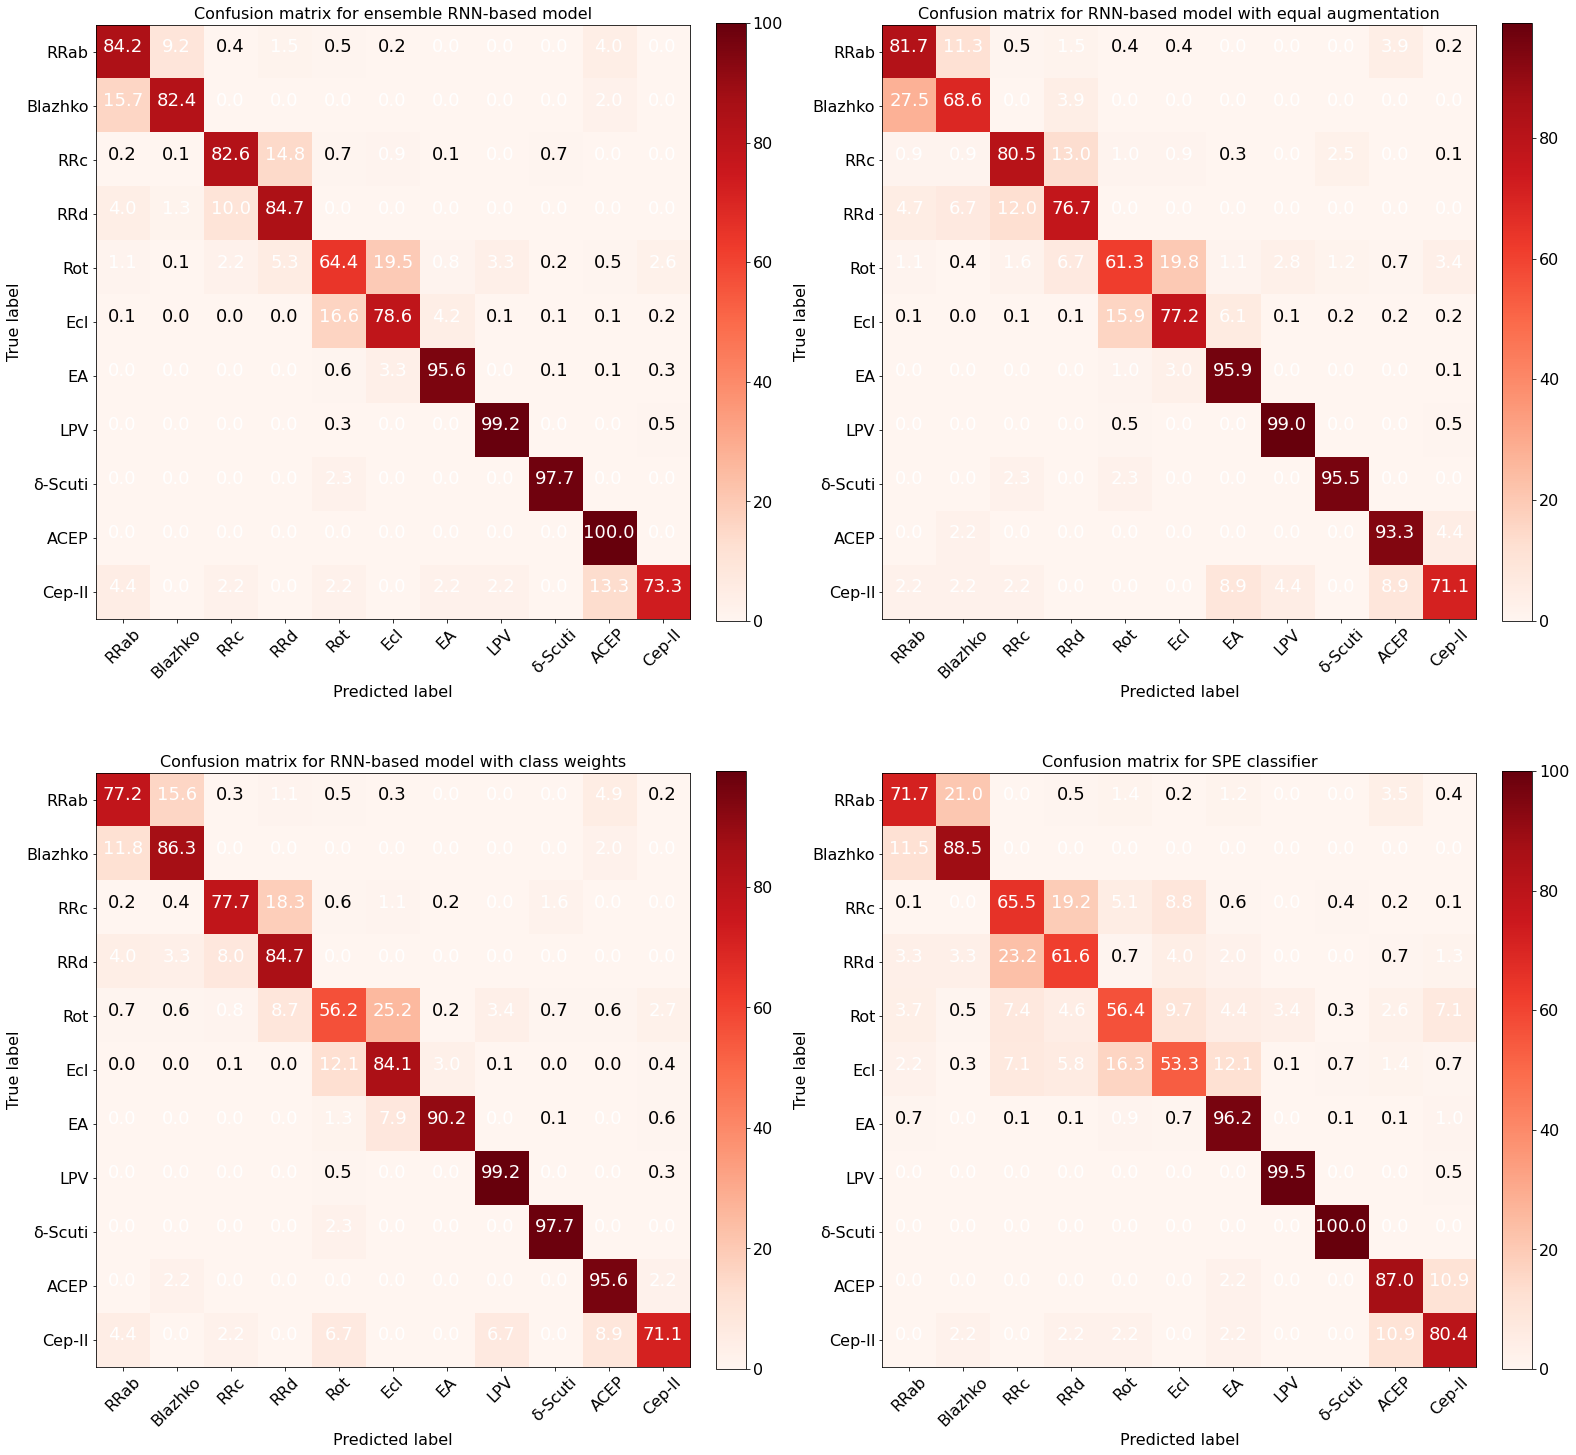

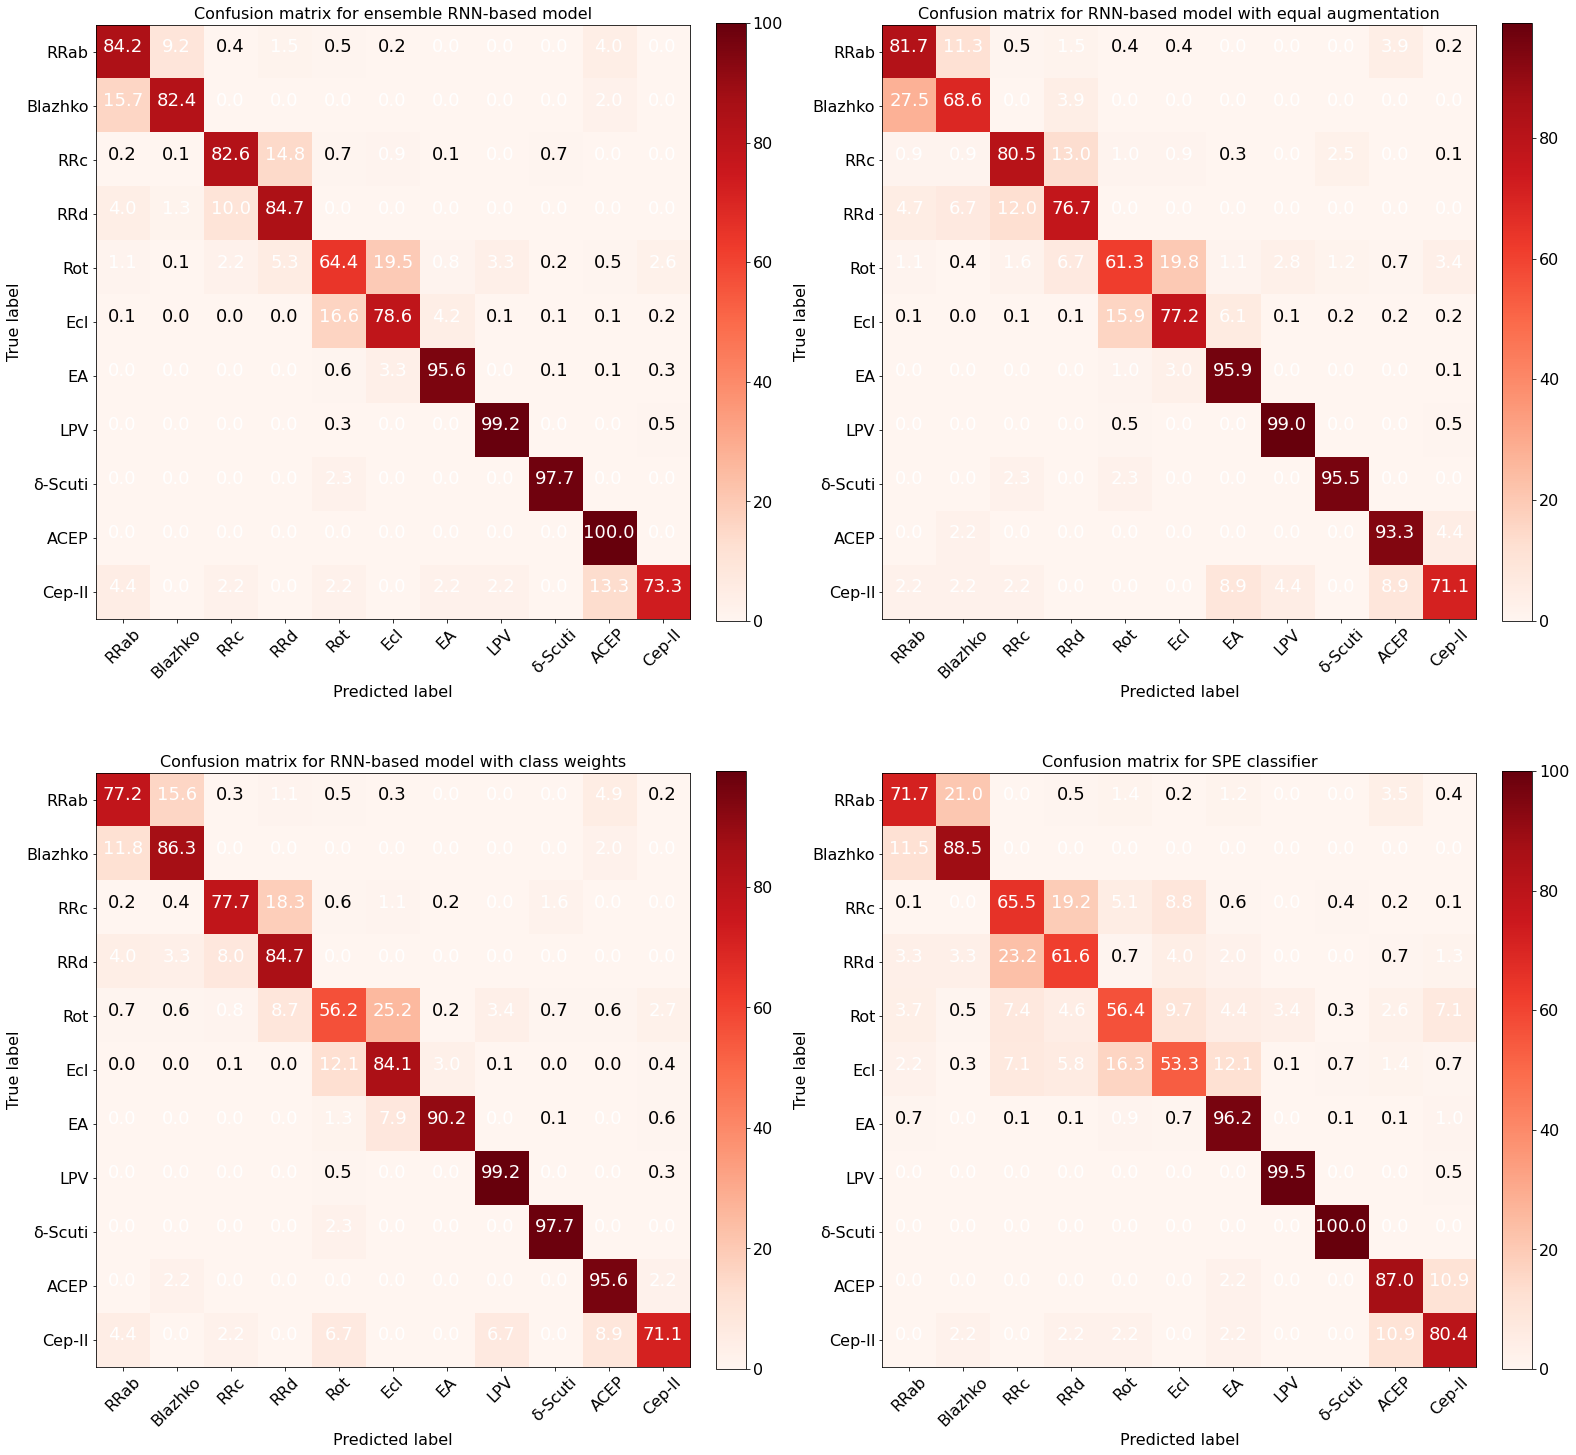

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle

f = open('y_pre_and_y_label_ensemble', 'rb')
y_predicted, y_label = pickle.load(f)
cm1 = confusion_matrix(y_true=y_label, y_pred=y_predicted, normalize='true', 
                       labels=[0,3,1,2,6,4,5,7,8,9,10])

f = open('y_pre_and_y_label_equal', 'rb')
y_predicted, y_label = pickle.load(f)
cm2 = confusion_matrix(y_true=y_label, y_pred=y_predicted, normalize='true', 
                       labels=[0,3,1,2,6,4,5,7,8,9,10])

f = open('y_pre_and_y_label_weight', 'rb')
y_predicted, y_label = pickle.load(f)
cm3 = confusion_matrix(y_true=y_label, y_pred=y_predicted, normalize='true', 
                       labels=[0,3,1,2,6,4,5,7,8,9,10])

data = pd.read_csv("conf_mat.csv",header=None)
y_label = []
y_predicted = []
for true_label in range(0,11):
    for predicted_label in range(0,11):
        for i in range(0,data[predicted_label][true_label]):
            y_label.append(true_label)
            y_predicted.append(predicted_label)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm4 = confusion_matrix(y_true=y_label, y_pred=y_predicted, normalize='true', 
                       labels=[0,3,1,2,6,4,5,7,8,9,10])

classes = ['RRab', 'Blazhko','RRc','RRd','Rot', 'Ecl', 'EA' , 'LPV','δ-Scuti','ACEP', 'Cep-II']

plot_4_confusion_matrixs(cm1,cm2,cm3,cm4, classes, normalize=True)